#  IF4140 | EDA

Group Members:
- Muhammad Fadli Alfarizi (13121140)
- Aji Andhika Falah (13520012)


## Import Libraries

In [17]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from prefixspan import PrefixSpan
from pymining import seqmining
from scipy.stats import skew, kurtosis
from collections import Counter

## Import Dataset

In [27]:
df = pd.read_csv('https://drive.google.com/uc?id=1mIMT-kzQiyS5U5gHTA1V70Pvs7ya6dJ8', nrows=30000)

df.reset_index(drop=True, inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Date'] = df['Date'].astype('int64') // 10 ** 9

df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,1575849600,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,1575849600,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,1575849600,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,1575849600,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,1575849600,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


## 1. EDA

In [28]:
df.info()

print(f"\nshape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionNo  30000 non-null  object 
 1   Date           30000 non-null  int64  
 2   ProductNo      30000 non-null  object 
 3   ProductName    30000 non-null  object 
 4   Price          30000 non-null  float64
 5   Quantity       30000 non-null  int64  
 6   CustomerNo     29998 non-null  float64
 7   Country        30000 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.8+ MB

shape: (30000, 8)


In [29]:
# check missing values

print(df.isnull().sum())

print(f"\nnumber of missing values: {df.isnull().sum().sum()}")

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       2
Country          0
dtype: int64

number of missing values: 2


In [30]:
# check number of duplicates

print(f"number of duplicates {df.duplicated().sum()}")

number of duplicates 213


In [31]:
# check number of cancelled orders based on 'TransactionNo'
print(f"number of cancelled orders: {df['TransactionNo'].str.contains('C').sum()}")

# check number of cancelled orders based on -1 on 'Quantity'
print(f"number of cancelled orders: {df[df['Quantity'] == -1].shape[0]}")


number of cancelled orders: 422
number of cancelled orders: 178


In [32]:
"""
There is a transaction with 80k 'Quantity'
"""

df.sort_values('Quantity', ascending=False)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
142,581483,1575849600,23843,Paper Craft Little Birdie,12.38,80995,16446.0,United Kingdom
6288,581458,1575763200,22197,Popcorn Holder,6.04,1500,17949.0,United Kingdom
21660,580363,1575244800,23582,Vintage Doily Jumbo Bag Red,6.19,1500,13868.0,United Kingdom
8560,581175,1575676800,23084,Rabbit Night Light,6.19,1440,14646.0,Netherlands
7445,581115,1575676800,22413,Metal Sign Take It Or Leave It,6.19,1404,15195.0,United Kingdom
...,...,...,...,...,...,...,...,...
12238,C580913,1575590400,22536,Magic Drawing Slate Purdey,6.19,-120,17857.0,United Kingdom
6511,C581406,1575763200,46000M,Polyester Filler Pad 45x45cm,6.19,-240,NaN,United Kingdom
12294,C580971,1575590400,22313,Office Mug Warmer Pink,6.19,-250,14298.0,United Kingdom
6512,C581406,1575763200,46000S,Polyester Filler Pad 40x40cm,6.19,-300,NaN,United Kingdom


In [33]:
"""
Recheck the cancelled orders

It can be observed that the order is cancelled
"""

df[df['Quantity'] < 0].sort_values('Quantity', ascending=True)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
1616,C581484,1575849600,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom
6512,C581406,1575763200,46000S,Polyester Filler Pad 40x40cm,6.19,-300,NaN,United Kingdom
12294,C580971,1575590400,22313,Office Mug Warmer Pink,6.19,-250,14298.0,United Kingdom
6511,C581406,1575763200,46000M,Polyester Filler Pad 45x45cm,6.19,-240,NaN,United Kingdom
12238,C580913,1575590400,22536,Magic Drawing Slate Purdey,6.19,-120,17857.0,United Kingdom
...,...,...,...,...,...,...,...,...
17592,C580711,1575504000,23243,Set Of Tea Coffee Sugar Tins Pantry,6.19,-1,16057.0,United Kingdom
19620,C580507,1575417600,22423,Regency Cakestand 3 Tier,6.19,-1,15867.0,United Kingdom
19621,C580507,1575417600,72351B,Set/6 Pink Butterfly T-Lights,6.19,-1,15867.0,United Kingdom
17578,C580686,1575504000,22358,Kings Choice Tea Caddy,6.19,-1,15984.0,United Kingdom


              Date     Price  Quantity
Date      1.000000  0.050329 -0.000100
Price     0.050329  1.000000  0.025011
Quantity -0.000100  0.025011  1.000000


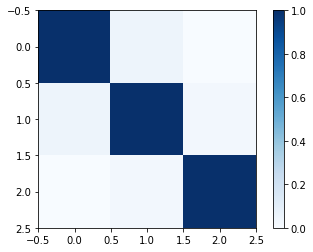

In [34]:
# Correlation diagram date, price, dan quantity
matrix = df[['Date', 'Price', 'Quantity']].corr()
print(matrix)

plt.imshow(matrix, cmap="Blues")
plt.colorbar()

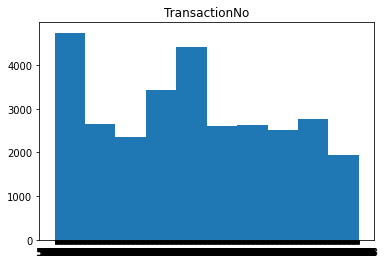

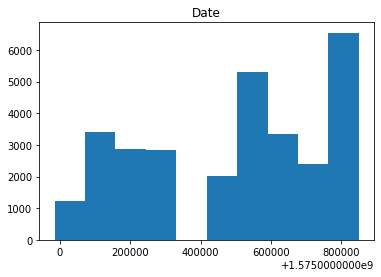

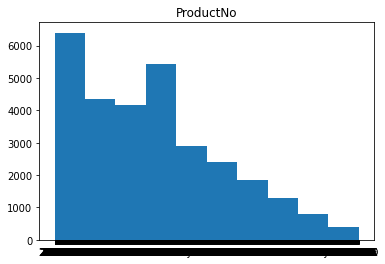

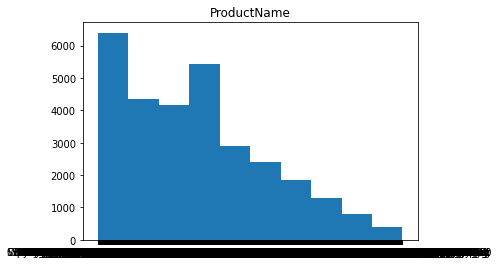

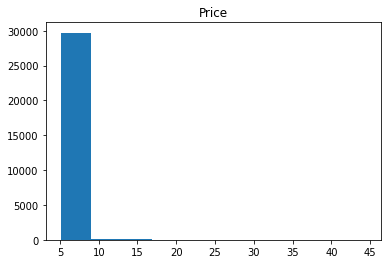

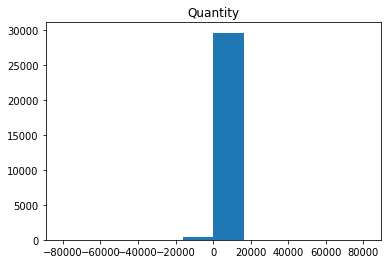

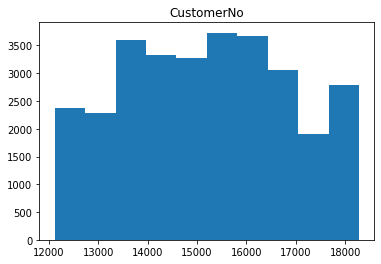

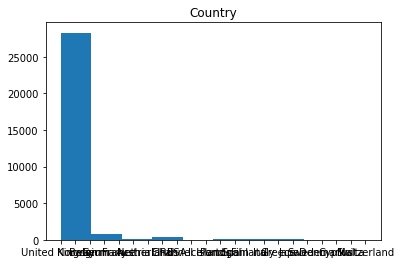

In [35]:
# Histogram feature
for i in df.columns:
    
    plt.figure()
    plt.title(f'{i}')
    plt.hist(df[i])

In [36]:
# Skewness dan Kurtosis
print("Date\nSkewness:", skew(df[['Date']]), "\nkurtosis:", kurtosis(df[['Date']]))
print("Price\nSkewness:", skew(df[['Price']]), "\nkurtosis:", kurtosis(df[['Price']]))
print("Quantity\nSkewness:", skew(df[['Quantity']]), "\nkurtosis:", kurtosis(df[['Quantity']]))

Date
Skewness: [-0.25707149] 
kurtosis: [-1.23305231]
Price
Skewness: [11.83956139] 
kurtosis: [245.38702169]
Quantity
Skewness: [-0.03799699] 
kurtosis: [14925.58867255]


## 2. Data Preprocessing

In [37]:
# remove duplicates value
df_duplicates_removed = df.drop_duplicates()

# remove missing values
df_missing_values_removed = df_duplicates_removed.dropna()

In [38]:
print(f"shape before cancelled orders are removed: {df_missing_values_removed.shape}")

# remove cancelled orders
df_cancelled_orders_removed = df_missing_values_removed[~df_missing_values_removed['TransactionNo'].str.contains('C')]
df_cancelled_orders_removed = df_missing_values_removed[df_missing_values_removed['Quantity'] > 0]

order_cancelled = df_missing_values_removed[df_missing_values_removed['Quantity'] < 0]
order_cancelled.loc[:, 'Quantity'] = order_cancelled['Quantity'] * -1

print(f"shape after cancelled orders are removed (step 1): {df_cancelled_orders_removed.shape}")

columns = ['ProductNo', 'Quantity', 'CustomerNo']

df_merged = pd.merge(df_cancelled_orders_removed, order_cancelled,
                     on=columns,
                     how='inner', suffixes=('_df_cancelled_orders_removed', '_order_cancelled'))

# Step 1: Create tuples for comparison
df_cancelled_orders_removed_tuples = df_cancelled_orders_removed.apply(
    lambda row: (row['TransactionNo'], row['ProductNo'], row['Quantity'], row['CustomerNo']), axis=1
)
df_merged_tuples = df_merged.apply(
    lambda row: (
        row['TransactionNo_df_cancelled_orders_removed'], row['ProductNo'], row['Quantity'], row['CustomerNo']), axis=1
)
rows_to_remove = df_cancelled_orders_removed_tuples.isin(df_merged_tuples)
df_cancelled_orders_removed = df_cancelled_orders_removed[~rows_to_remove]

print(f"shape after cancelled orders are removed (step 2): {df_cancelled_orders_removed.shape}")

df_cancelled_orders_removed.sort_values('Quantity', ascending=False)

shape before cancelled orders are removed: (29785, 8)
shape after cancelled orders are removed (step 1): (29366, 8)


C:\Users\Aji\AppData\Local\Temp\ipykernel_17440\2031731149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_cancelled.loc[:, 'Quantity'] = order_cancelled['Quantity'] * -1


shape after cancelled orders are removed (step 2): (29322, 8)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
6288,581458,1575763200,22197,Popcorn Holder,6.04,1500,17949.0,United Kingdom
21660,580363,1575244800,23582,Vintage Doily Jumbo Bag Red,6.19,1500,13868.0,United Kingdom
8560,581175,1575676800,23084,Rabbit Night Light,6.19,1440,14646.0,Netherlands
7445,581115,1575676800,22413,Metal Sign Take It Or Leave It,6.19,1404,15195.0,United Kingdom
6289,581459,1575763200,22197,Popcorn Holder,6.04,1200,17949.0,United Kingdom
...,...,...,...,...,...,...,...,...
2995,581219,1575763200,79144B,Painted Lightbulb Star+ Moon,6.19,1,16219.0,United Kingdom
20766,580287,1575244800,79066K,Retro Mod Tray,7.24,1,14594.0,United Kingdom
20767,580287,1575244800,23070,Edwardian Heart Photo Frame,7.24,1,14594.0,United Kingdom
20768,580287,1575244800,22173,Metal 4 Hook Hanger French Chateau,7.24,1,14594.0,United Kingdom


In [39]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)

        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index

        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]

    print('Total number of outliers is:', out1.shape[0]+out2.shape[0])

    return multiple_outliers

In [51]:
# detecting outliers
numeric_columns = (list(df.loc[:, ['Date', 'Price', 'Quantity']]))
Outliers_IQR = IQR_method(df,1,numeric_columns)
print(Outliers_IQR)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

df = df_out
df

Total number of outliers is: 2072
[]


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,1575849600,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,1575849600,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
2,581475,1575849600,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
3,581475,1575849600,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
4,581475,1575849600,22118,Joy Wooden Block Letters,11.53,18,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
28800,579408,1574985600,22997,Travel Card Wallet Union Jack,6.19,2,14701.0,United Kingdom
28801,579408,1574985600,23000,Travel Card Wallet Transport,6.04,4,14701.0,United Kingdom
28802,579408,1574985600,23005,Travel Card Wallet I Love London,6.04,3,14701.0,United Kingdom
28803,579408,1574985600,23002,Travel Card Wallet Skulls,6.04,5,14701.0,United Kingdom


## 3. Modeling (Sequential Pattern Mining)

In [17]:
from itertools import combinations

df_transformed = df_cancelled_orders_removed

# CONFIG
num_customers = 10

# overall performance evaluation
overall_true_positives = 0
overall_false_positives = 0
overall_false_negatives = 0
overall_true_negatives = 0

for customer_no in df_transformed['CustomerNo'].unique()[:num_customers]:
    # Extract transactions of the customer
    customer_data = df_transformed[df_transformed['CustomerNo'] == customer_no]
    customer_data = customer_data.sort_values(['Date', 'TransactionNo'])

    transactions = customer_data.groupby('TransactionNo')['ProductNo'].apply(list).tolist()

    # Split train and test
    split_index = int(len(transactions) * 0.7)
    train_transactions = transactions[:split_index]
    test_transactions = transactions[split_index:]

    # Sequential pattern mining
    min_support = 4
    patterns = list(seqmining.freq_seq_enum(train_transactions, min_support))

    # Performance evaluation for the current customer
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    tracker = {}
    for pattern, _ in patterns:
        if len(pattern) < 2:
            continue

        for product1, product2 in combinations(pattern, 2):
            if f"{product1}:{product2}" in tracker:
                continue
            else:
                tracker[f"{product1}:{product2}"] = True

            first_index = None
            second_index = None
            is_false_positive = True
            for idx, transaction in enumerate(test_transactions):
                if product1 in transaction and first_index is None:
                    first_index = idx

                if product2 in transaction and (second_index is None or idx > second_index):
                    second_index = idx

                if first_index and second_index and first_index < second_index:
                    true_positives += 1
                    is_false_positive = True
                    break

            if is_false_positive:
                false_positives += 1

        # TODO: true_negative and false_negative

    overall_true_positives += true_positives
    overall_false_positives += false_positives
    overall_false_negatives += false_negatives
    overall_true_negatives += true_negatives

# TODO: incorporate true_negative and false_negative
print(f"accuracy: {(100 * overall_true_positives) / (overall_true_positives + overall_false_positives):.2f}%")

accuracy: 20.00%


In [18]:
precision = overall_true_positives / (overall_true_positives + overall_false_positives) if (
                                                                                                   overall_true_positives + overall_false_positives) > 0 else 0
recall = overall_true_positives / (overall_true_positives + overall_false_negatives) if (
                                                                                                overall_true_positives + overall_false_negatives) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (overall_true_positives + overall_true_negatives) / (
        overall_true_positives + overall_true_negatives + overall_false_positives + overall_false_negatives)

metrics = {
    "Metric": ["True Positives", "False Positives", "False Negatives", "True Negatives",
               "Precision", "Recall", "F1 Score", "Accuracy"],
    "Value": [overall_true_positives, overall_false_positives, overall_false_negatives, overall_true_negatives,
              f"{precision:.2f}", f"{recall:.2f}", f"{f1_score:.2f}", f"{accuracy:.2f}"]
}

pd.DataFrame(metrics)

,Metric,Value
0,True Positives,3
1,False Positives,12
2,False Negatives,0
3,True Negatives,0
4,Precision,0.20
5,Recall,1.00
6,F1 Score,0.33
7,Accuracy,0.20
